In [1]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import TwoSlopeNorm

import netket as nk
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import json

from pylanczos import PyLanczos

### Generate Table of All Possible States Indexed in Lexigraphical Order

In [2]:
def generateStateTable(n,n0,N): # assumes ab > n0 > 0 and N = n choose n0
    states = []
    state = np.concatenate((np.ones(a*b-n0),-1*np.ones(n0))).astype(int)
    for i in range(0,N):
        states.append(np.copy(state))
        j = 0
        flag = True
        flip_count = 0
        up_count = 0
        while (flag): 
            if (j == n-1):
                for m in range(0,n):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                if (flip_count == 1):
                    break
            if (state[j] != 1):
                j += 1  
            elif (state[j+1] != 1):
                for m in range(0,j):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                    if (state[m] == 1):
                        up_count += 1
                if (flip_count == 1):
                    state[j],state[j+1] = state[j+1],state[j]
                    for k in range(1,up_count+1):
                        state[j-k],state[k-1] = state[k-1],state[j-k]
                else:
                    state[j],state[j+1] = state[j+1],state[j]
                flag = False
            else:
                j += 1
    return states

a = 4 # width of lattice
b = 4 # height of lattice
n = a*b # number of sites in lattice
n0 = n // 2 # number of down spins in the string
N = int(math.factorial(a*b)/(math.factorial(n0)*math.factorial(a*b-n0))) # number of states

stateTable = generateStateTable(n,n0,N)
print(stateTable)

[array([ 1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1]), array([ 1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1]), array([ 1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1]), array([ 1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1]), array([ 1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1]), array([ 1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1]), array([ 1,  1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1]), array([ 1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1]), array([-1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1]), array([ 1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1]), array([ 1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1]), array([ 1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1]), array([ 1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1]), array([ 1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,

In [3]:
def coeffMatrix(a,b): # assumes periodic boundary conditions
    n = a*b
    J = np.full((n,n),0)

    # first neighbors
    for i in range(0,n):
        for j in range(0,n):
            rowdistance = np.abs((i // a) - (j // a)) # how many rows apart i and j are
            coldistance = np.abs((i % a) - (j % a)) # how many columns apart i and j are
            if ((rowdistance == 0 and (coldistance == 1 or coldistance == a-1)) or (coldistance == 0 and (rowdistance == 1 or rowdistance == b-1))):
                J[i][j] = 1

    return J

J = coeffMatrix(a,b)
print(J)

[[0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0]
 [1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1]
 [0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0]]


### Compute Hamiltonian of the System

In [4]:
def computeHamiltonian():
    # uses the fact that the Hamiltonian is real and Hermitian => symmetric
    H = np.full((N,N),0)

    for i in range(0,N):
        for j in range(i,N):
            if (i == j):
                for k in range(0,n-1):
                    for l in range(k,n):
                        if (J[k][l] != 0):
                            H[i][j] += J[k][l]*stateTable[i][k]*stateTable[i][l]
            else:
                tempState = np.multiply(stateTable[i],stateTable[j])
                if (np.count_nonzero(tempState == -1) == 2):
                    indices = np.where(tempState == -1)
                    e,f = indices[0][0],indices[0][1]
                    if(J[e][f] != 0):
                        H[i][j] += 2*J[e][f]
                        H[j][i] += 2*J[e][f]
    return H

startTime = time.time()
H = computeHamiltonian()
endTime = time.time()

print(H)
print(endTime-startTime)


[[16  0  0 ...  0  0  0]
 [ 0  8  2 ...  0  0  0]
 [ 0  2  8 ...  0  0  0]
 ...
 [ 0  0  0 ...  8  2  0]
 [ 0  0  0 ...  2  8  0]
 [ 0  0  0 ...  0  0 16]]
171.59672474861145


### Visualize Sparse Hamiltonian Matrix

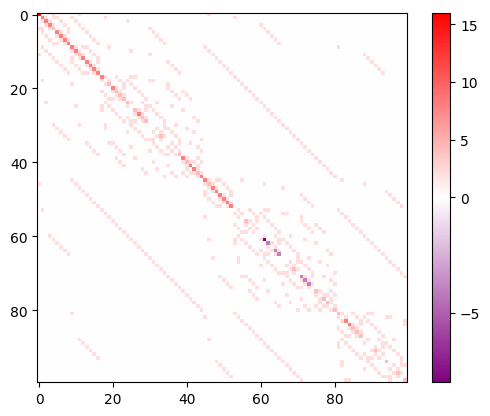

In [5]:
def sparsePlot(A):
    norm = TwoSlopeNorm(vcenter=0)
    plt.imshow(A,cmap=colors.LinearSegmentedColormap.from_list("", ["purple","white","red"]),interpolation=None,norm=norm)
    plt.colorbar()

sparsePlot(H[0:100,0:100])

### Exact Diagonalization

In [6]:
engine = PyLanczos(H.astype(np.float32), False, 1)
groundEnergy, groundState = engine.run()

print(groundEnergy)

[-44.91394]


### Compare Results to NetKet

[[16.  0.  0. ...  0.  0.  0.]
 [ 0.  8. -2. ...  0.  0.  0.]
 [ 0. -2.  8. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  8. -2.  0.]
 [ 0.  0.  0. ... -2.  8.  0.]
 [ 0.  0.  0. ...  0.  0. 16.]]
The exact ground-state energy is E0= -44.913932833715485


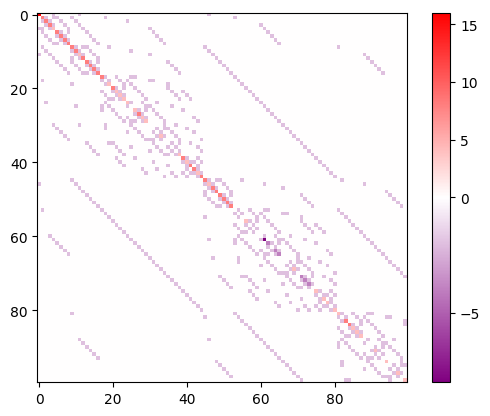

In [7]:
lattice = nk.graph.Grid(extent=[a,b], pbc=True)
hilbertSpace = nk.hilbert.Spin(s=0.5, total_sz=0.5*(n-2*n0), N=a*b)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbertSpace, graph=lattice)

netketH = hamiltonian.to_sparse().toarray()
print(netketH)
sparsePlot(netketH[0:100,0:100])

evals = nk.exact.lanczos_ed(hamiltonian)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

### Visualize Lattices

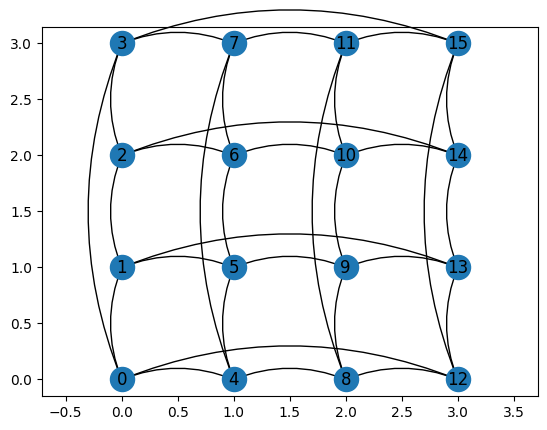

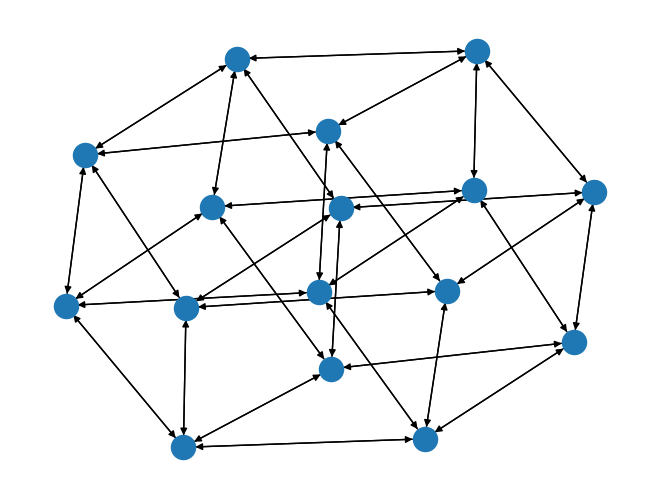

In [8]:
lattice.draw()
plt.show()

import networkx as nx 
G = nx.DiGraph() 

for i in range(np.shape(J)[0]): 
 for j in range(np.shape(J)[0]): 
   if J[i][j] != 0: 
      G.add_edge(i,j) 
nx.draw(G) 
plt.show()

